In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.stats import poisson, skellam
from scipy.optimize import minimize
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16,9) 

In [2]:
def poisson_tournament(df_matches, poisson_model, N):
    inicio = datetime.now()
    
    df_match = df_matches[df_matches.Jugado == 0]
    
    index = range(df_match.shape[0])
    columns = range(1,N+1)

    sim_poisson_local = pd.DataFrame(index=index, columns=columns)
    sim_poisson_away = pd.DataFrame(index=index, columns=columns)
    sim_poisson_local['idMatch'] = df_match.index
    sim_poisson_local['Local'] = df_match.Local.values
    sim_poisson_away['idMatch'] = df_match.index
    sim_poisson_away['Visita'] = df_match.Visita.values
    
    sim_poisson_local.set_index(['idMatch',"Local"], inplace = True)
    sim_poisson_away.set_index(['idMatch',"Visita"], inplace = True)
    
    for i, id_match in tqdm(enumerate(df_match.index)):
        local = df_match.iloc[i].Local
        away = df_match.iloc[i].Visita
        lambda_local = poisson_model.predict(pd.DataFrame(data={'Equipo':local, 'Rival':away, 'Localia':1}, index = [1]))
        lambda_away = poisson_model.predict(pd.DataFrame(data={'Equipo':away, 'Rival':local, 'Localia':0}, index = [1]))
        goles_local = np.random.poisson(lambda_local, N)
        goles_visita = np.random.poisson(lambda_away, N)
        
        sim_poisson_local.iloc[i] = goles_local
        sim_poisson_away.iloc[i] = goles_visita
    
    final = datetime.now()
    print(final-inicio)
    return sim_poisson_local, sim_poisson_away

In [42]:
def current_table(df, teams):
    columns = ["Posición","Equipo","PJ","Puntos","DG","GF","GC"]
    df_table = pd.DataFrame(index = range(len(teams)), columns = columns)
    for t,team in enumerate(teams):
        rend_local = df[(df.Local == team)&(df.Jugado == 1)]
        rend_visita = df[(df.Visita == team)&(df.Jugado == 1)]

        pts_local = len(rend_local[rend_local.GL > rend_local.GV])*3 + len(rend_local[rend_local.GL == rend_local.GV])
        pts_visita = len(rend_visita[rend_visita.GL < rend_visita.GV])*3 + len(rend_visita[rend_visita.GL == rend_visita.GV])
        pts = pts_local + pts_visita

        goles_favor = rend_local.GL.sum() + rend_visita.GV.sum()
        goles_contra = rend_local.GV.sum() + rend_visita.GL.sum()
        dif_goles = goles_favor - goles_contra

        pj = df[((df.Local == team) | (df.Visita == team))&(df.Jugado == 1)].shape[0]
        df_table.at[t] = [0, team, pj, pts, dif_goles, goles_favor, goles_contra]
     
    df_table.sort_values(by=["Puntos","DG","GF","GC"], inplace = True, ascending = False)
    df_table["Posición"] = range(1,19)
    df_table.set_index("Equipo", inplace = True)
    df_tabla_2020.to_csv("Tabla2020.csv")
    return df_table

In [4]:
def summary_positions(sim_poisson_local, sim_poisson_visita, N_sim, teams, df_tabla_2019, df_tabla_2020):
    #team, n_sim, posición
    team_stats = []
    for n_sim in tqdm(range(1,N_sim+1)):
        df_table_sim = df_tabla_2020.copy()
        for team in teams:
            #info partidos de local
            a = sim_poisson_local[sim_poisson_local.index.get_level_values("Local") == team].reset_index().drop("Local", axis = 1).set_index("idMatch")
            b = sim_poisson_visita[sim_poisson_visita.index.get_level_values("Visita") == team].reset_index().drop("Visita", axis = 1).set_index("idMatch")

            #info partidos de visita
            aa = sim_poisson_visita[sim_poisson_visita.index.get_level_values(0).isin(a.index.get_level_values("idMatch"))].reset_index().drop("Visita", axis = 1).set_index("idMatch")
            bb = sim_poisson_local[sim_poisson_local.index.get_level_values(0).isin(b.index.get_level_values("idMatch"))].reset_index().drop("Local", axis = 1).set_index("idMatch")

            pts = 3*(sum(a[n_sim] > aa[n_sim])) + (sum(a[n_sim] == aa[n_sim])) + 3*(sum(b[n_sim] > bb[n_sim])) + (sum(b[n_sim] == b[n_sim]))
            gf = sum(a[n_sim])
            gc = sum(b[n_sim])

            df_table_sim.loc[team, "PJ"] = 34
            df_table_sim.loc[team, "Puntos"] = df_table_sim.loc[team, "Puntos"] + pts
            df_table_sim.loc[team, "DG"] = df_table_sim.loc[team, "DG"] + (gf-gc)
            df_table_sim.loc[team, "GF"] = df_table_sim.loc[team, "GF"] + gf
            df_table_sim.loc[team, "GC"] = df_table_sim.loc[team, "GC"] + gc

            df_table_sim.sort_values(by=["Puntos","DG","GF","GC"], inplace = True, ascending = False)
            df_table_sim["Posición"] = range(1,18+1)

        df_tabla_pond = tabla_pond(teams, df_tabla_2019, df_table_sim)
        for team in teams:
            team_stats.append([team, "Absoluta", n_sim, df_table_sim.loc[team, "Posición"]])
            team_stats.append([team, "Ponderada", n_sim, df_tabla_pond.loc[team, "Posición"]])

    df_posicion = pd.DataFrame(team_stats, columns = ["Equipo","Tabla","n_sim","Posición"])
    df_posicion.to_csv("df_posicion.csv")
    return df_posicion

In [5]:
def tabla_pond(teams, df_tabla_2019, df_tabla_2020):
    pond_19 = 0.6
    pond_20 = 0.4
    pond_team_stats = []
    for team in teams:
        pts_2020 = df_tabla_2020.loc[team]["Puntos"]
        pj_2020 = df_tabla_2020.loc[team]["PJ"]
        if team in ["Santiago Wanderers","La Serena"]:
            score = pts_2020/pj_2020
        else:
            pts_2019 = df_tabla_2019.loc[team]["PTS"]
            pj_2019 = df_tabla_2019.loc[team]["PJ"]
            score = (pts_2019/pj_2019)*0.6 + (pts_2020/pj_2020)*0.4

        pond_team_stats.append([team, pts_2019, pts_2020, score])
    df_tabla_pond = pd.DataFrame(pond_team_stats, columns = ["Equipo","2019","2020","Score"])
    df_tabla_pond.sort_values(by=["Score"], ascending = False, inplace = True)
    df_tabla_pond["Posición"] = range(1,df_tabla_pond.shape[0]+1)
    df_tabla_pond["Score"] = df_tabla_pond.Score.round(3)
    df_tabla_pond.set_index("Equipo", inplace = True)
    return df_tabla_pond

In [45]:
def relegation_match_simulation(team_1, team_2, poisson_model):
    lambda_local = poisson_model.predict(pd.DataFrame(data={'Equipo':team_1, 'Rival':team_2, 'Localia':0}, index = [1]))
    lambda_away = poisson_model.predict(pd.DataFrame(data={'Equipo':team_2, 'Rival':team_1, 'Localia':0}, index = [1]))
    goles_local = np.random.poisson(lambda_local)[0]
    goles_visita = np.random.poisson(lambda_away)[0]
    if goles_local > goles_visita:
        ganador = team_1
    elif goles_local < goles_visita:
        ganador = team_2
    else:
        ganador = np.random.choice([team_1, team_2])
    return ganador

In [48]:
def relegation_stats(N_sim, df_posicion, poisson_model):
    # cuantificar cuántas veces no se juega partido de definición por temas de casos difusos
    desc_directo_1, desc_directo_2, desc_directo_3 = 0, 0, 0
    desc_stats = []
    for n_sim in tqdm(range(1,N_sim+1)):
        # Tabla Absoluta (2020)
        ult_abs = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Absoluta")&
                              (df_posicion.Posición == 18)]["Equipo"].iloc[0]
        pen_abs = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Absoluta")&
                              (df_posicion.Posición == 17)]["Equipo"].iloc[0]
        ant_abs = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Absoluta")&
                              (df_posicion.Posición == 16)]["Equipo"].iloc[0]

        # Tabla Ponderada (2019-2020)
        ult_pon = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Ponderada")&
                              (df_posicion.Posición == 18)]["Equipo"].iloc[0]
        pen_pon = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Ponderada")&
                              (df_posicion.Posición == 17)]["Equipo"].iloc[0]
        ant_pon = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Ponderada")&
                              (df_posicion.Posición == 16)]["Equipo"].iloc[0]

        # primer descendido: último de la absoluta
        desc_1 = ult_abs
        n_desc_1 = "Último Absoluta"
        if ult_abs == ult_pon:
            desc_2 = pen_pon
            n_desc_2 = "Penúltimo Ponderada"
            if pen_abs == pen_pon:
                desc_directo_1 += 1
                if ant_abs == ant_pon:
                    desc_3 = ant_abs
                    n_desc_3 = "Antepenúltimo Ponderada y Absoluta"
                elif ant_abs != ant_pon:
                    desc_3 = match_simulation(ant_abs, ant_pon, poisson_model)
                    n_desc_3 = "Partido Ant Abs vs Ant Pon"
            else: #pen_abs != pen_pon
                if pen_abs == ant_pon:
                    desc_3 = pen_abs
                    n_desc_3 = "Penúltimo Absoluta"
                else: #pen_abs != ant_pon
                    desc_3 = match_simulation(pen_abs, ant_pon, poisson_model)
                    n_desc_3 = "Partido Pen Abs vs Ant Pon"
        else: #ult_abs != ult_pon
            desc_2 = ult_pon
            n_desc_2 = "Último Ponderada"
            if ult_abs == pen_pon:
                if pen_abs == ult_pon:
                    desc_directo_2 +=1
                    desc_3 = match_simulation(ant_abs, ant_pon, poisson_model)
                    n_desc_3 = "Partido Ant Abs vs Ant Pon"
                else: # pen_abs != ult_pon
                    desc_3 = match_simulation(pen_abs, ant_pon, poisson_model)
                    n_desc_3 = "Partido Pen Abs vs Ant Pon"
            
            else: #ult_abs != pen_pon
                if pen_abs == ult_pon:
                    desc_directo_3 += 1
                    desc_3 = match_simulation(ant_abs, pen_pon, poisson_model)
                    n_desc_3 = "Partido Ant Abs vs Pen Pon"
                else: #pen_abs != pen_pon
                    desc_3 = match_simulation(pen_abs, pen_pon, poisson_model)
                    n_desc_3 = "Partido Pen Abs vs Pen Pon"

        descendidos = {desc_1, desc_2, desc_3}
        n_desc = len(descendidos)
        if n_desc != 3:
            print("Error de casos")
            print("----------")
            print(ult_abs, pen_abs, ant_abs)
            print(ult_pon, pen_pon, ant_pon)
            print(n_sim, desc_1, "--", n_desc_1)
            print(n_sim, desc_2, "--", n_desc_2)
            print(n_sim, desc_3, "--", n_desc_3)
        else:
            desc_stats.append([n_sim, desc_1, "1", n_desc_1])
            desc_stats.append([n_sim, desc_2, "2", n_desc_2])
            desc_stats.append([n_sim, desc_3, "3", n_desc_3])
        df_desc_stats = pd.DataFrame(desc_stats, columns = ["n_sim","Equipo","Desc","Motivo"])
    
    print(desc_directo_1, desc_directo_2, desc_directo_3)
    df_desc_stats.to_csv("df_desc_stats.csv")
    return df_desc_stats

In [61]:
def cases_distribution(df_posicion, N_sim):
    df_last = df_posicion[df_posicion["Posición"].isin([16,17,18])]

    l1a, l1b = 0, 0
    l2a, l2b, l2c, l2d = 0, 0, 0, 0
    l3a, l3b, l3c, l3d, l3e, l3f = 0, 0, 0, 0, 0, 0

    matches_cd3 = []
    relegation_matches = []

    for n_sim in tqdm(df_last.n_sim.unique()):
        df_sim = df_last[(df_last.n_sim == n_sim)]
        # Absoluta
        A = df_sim[(df_sim.Tabla == "Absoluta")&(df_sim["Posición"] == 18)]["Equipo"].iloc[0]
        B = df_sim[(df_sim.Tabla == "Absoluta")&(df_sim["Posición"] == 17)]["Equipo"].iloc[0]
        C = df_sim[(df_sim.Tabla == "Absoluta")&(df_sim["Posición"] == 16)]["Equipo"].iloc[0]
        # Ponderada
        X = df_sim[(df_sim.Tabla == "Ponderada")&(df_sim["Posición"] == 18)]["Equipo"].iloc[0]
        Y = df_sim[(df_sim.Tabla == "Ponderada")&(df_sim["Posición"] == 17)]["Equipo"].iloc[0]
        Z = df_sim[(df_sim.Tabla == "Ponderada")&(df_sim["Posición"] == 16)]["Equipo"].iloc[0]

        if A == X: 
            l1a += 1
            if B == Y: 
                l2a += 1
                relegation_matches.append([n_sim, C, Z])
            elif B != Y: 
                l2b += 1
                if B == Z: l3a +=1
                elif B != Z: 
                    l3b += 1
                    relegation_matches.append([n_sim, B, Z])
        elif A != X: 
            l1b += 1
            if A == Y: 
                l2c += 1
                if B == X: 
                    l3c += 1
                    relegation_matches.append([n_sim, C, Z])
                elif B != X: 
                    l3d += 1
                    relegation_matches.append([n_sim, B, Z])
            elif A != Y: 
                l2d += 1
                if B == X:
                    l3e += 1
                    matches_cd3.append([n_sim, Y, C, A, X, B])
                    relegation_matches.append([n_sim, Y, Z])
                elif B != X: 
                    l3f += 1
                    relegation_matches.append([n_sim, B, Y])

    print("A = X", l1a/N_sim)
    print("A != X", l1b/N_sim)
    print("-------------------")
    print("A = X & B = Y", l2a/N_sim)
    print("A = X & B != Y", l2b/N_sim)
    print("A != X & A = Y", l2c/N_sim)
    print("A != X & A != Y", l2d/N_sim)
    print("-------------------")
    print("A = X & B != Y & B = Z", l3a/N_sim)
    print("A = X & B != Y & B != Z", l3b/N_sim)
    print("A != X & A = Y & B = X", l3c/N_sim)
    print("A != X & A = Y & B != X", l3d/N_sim)
    print("A != X & A != Y & B = X", l3e/N_sim)
    print("A != X & A != Y & B != X", l3f/N_sim)
    df_cd3 = pd.DataFrame(matches_cd3, columns = ["n_sim","PenPon","AntAbs","Des1","Des2","PenAbs"])
    df_rel_matches = pd.DataFrame(relegation_matches, columns = ["n_sim","team_1","team_2"])
    return (df_cd3, df_rel_matches)

## Lectura de datos

In [43]:
df = pd.read_csv("matches_chile.csv")
df_tabla_2019 = pd.read_csv("Tabla2019.csv", index_col = "Equipo")
df_tabla_2019.sort_values(by=["PTS","DG"], ascending = False, inplace = True)
teams = df.Local.unique()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fecha   306 non-null    int64  
 1   Local   306 non-null    object 
 2   Visita  306 non-null    object 
 3   GL      223 non-null    float64
 4   GV      223 non-null    float64
 5   Jugado  306 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 14.5+ KB


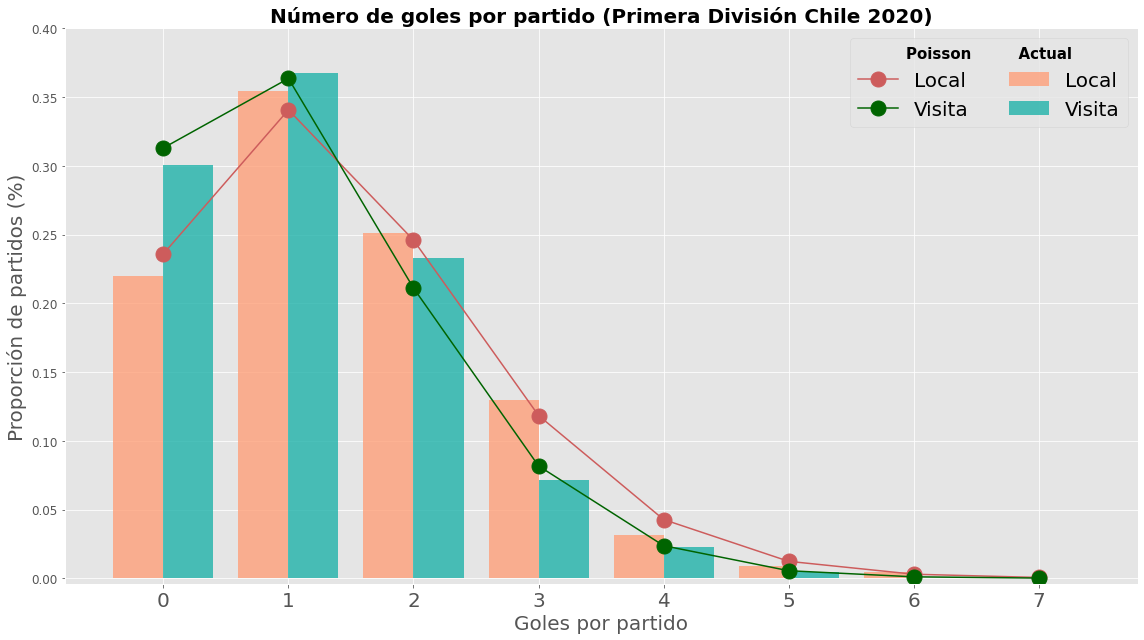

In [19]:
N_poisson = 8
poisson_pred = np.column_stack([[poisson.pmf(i, df[j].mean()) for i in range(N_poisson)] for j in ['GL','GV']])

#Graficar distribución actual de goles en el torneo
plt.hist(df[['GL','GV']].values, range(9), density = True, label = ['Local','Visita'], 
         alpha = 0.8, color=["#FFA07A", "#20B2AA"])

#Graficar predicción de goles según tasas de poisson (promedios local-visita)
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0], 
                  linestyle ='-', marker = 'o', label ='Local', color ='#CD5C5C', ms = 15)
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1], 
                  linestyle= '-', marker= 'o', label ='Visita', color ='#006400', ms = 15)

#Atributos del gráfico
leg = plt.legend(loc ='upper right', fontsize = 20, ncol = 2)
leg.set_title("Poisson         Actual", prop = {'size':'15', 'weight':'bold'})
plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)], size = 20)
plt.yticks(size = 12)
plt.xlabel("Goles por partido",size=20)
plt.ylabel("Proporción de partidos (%)",size=20)
plt.title("Número de goles por partido (Primera División Chile 2020)",size=20,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.savefig("poisson_dist.png")
plt.show()

## Ajustar modelo

Con datos de torneo 2020, solo partidos jugados

In [20]:
df_played = df[df.Jugado == 1]
goal_model_data = pd.concat([df_played[['Local','Visita','GL']].assign(Localia=1).rename(
            columns={'Local':'Equipo','Visita':'Rival','GL':'Goles'}),
           df_played[['Visita','Local','GV']].assign(Localia=0).rename(
            columns={'Visita':'Equipo','Local':'Rival','GV':'Goles'})])

poisson_model = smf.glm(formula="Goles ~ Localia + Equipo + Rival", data = goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Goles   No. Observations:                  446
Model:                            GLM   Df Residuals:                      410
Model Family:                 Poisson   Df Model:                           35
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -619.11
Date:                Tue, 29 Dec 2020   Deviance:                       446.02
Time:                        10:28:30   Pearson chi2:                     372.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.0353      0.261     -0.135      0.892      -0.547       0.477
Equipo[T.Audax Italiano]                0.0790      0.240      0.329      0.742      -0.392       0.550
Equipo[T.Cobresal]                     -0.0286      0.250     -0.115      0.909      -0.518       0.461
Equipo[T.Colo-Colo]                    -0.2097      0.264     -0.794      0.427      -0.728       0.308
Equipo[T.Coquimbo Unido]               -0.3375      0.271     -1.244      0.213      -0.869       0.194
Equipo[T.Curicó Unido]                 -0.1030      0.256     -0.402      0.688      -0.605       0.399
Equipo[T.Everton]                      -0.1110      0.252     -0.440      0.660      -0.605       0.383
Equipo[T.Huachipato]                   -0.1446      0.255     -0.568      0.570      -0.644       0.354
Equipo[T.Iquique]                      -0.1739      0.261     -0.665      0.506      -0.686       0.339
Equipo[T.La Serena]                    -0.2138      0.262     -0.817      0.414      -0.726       0.299
Equipo[T.O'Higgins]                    -0.0519      0.253     -0.205      0.838      -0.549       0.445
Equipo[T.Palestino]                    -0.0863      0.252     -0.342      0.732      -0.581       0.408
Equipo[T.Santiago Wanderers]            0.0380      0.246      0.155      0.877      -0.443       0.519
Equipo[T.Universidad Católica]          0.5436      0.223      2.435      0.015       0.106       0.981
Equipo[T.Universidad de Chile]          0.1529      0.239      0.641      0.521      -0.315       0.620
Equipo[T.Universidad de Concepción]    -0.1017      0.252     -0.403      0.687      -0.596       0.392
Equipo[T.Unión Española]                0.2700      0.231      1.167      0.243      -0.183       0.723
Equipo[T.Unión La Calera]               0.3523      0.234      1.505      0.132      -0.106       0.811
Rival[T.Audax Italiano]                 0.3517      0.244      1.442      0.149      -0.126       0.830
Rival[T.Cobresal]                       0.0670      0.262      0.256      0.798      -0.446       0.580
Rival[T.Colo-Colo]                      0.2735      0.250      1.093      0.274      -0.217       0.764
Rival[T.Coquimbo Unido]                 0.2257      0.251      0.900      0.368      -0.266       0.717
Rival[T.Curicó Unido]                   0.2434      0.256      0.952      0.341      -0.257       0.744
Rival[T.Everton]                        0.0518      0.260      0.199      0.842      -0.458       0.561
Rival[T.Huachipato]                     0.1406      0.258      0.544      0.586      -0.365       0.647
Rival[T.Iquique]                        0.2379      0.255      0.931      0.352      -0.263       0.739
Rival[T.La Serena]                      0.0681      0.264      0.25

## Simulación

In [21]:
np.random.seed(42)

In [22]:
N_sim = 10000
df_tabla_2020 = current_table(df, teams)
sim_poisson_local, sim_poisson_visita = poisson_tournament(df, poisson_model, N = N_sim)
df_posicion = summary_positions(sim_poisson_local, sim_poisson_visita, N_sim, teams, df_tabla_2019, df_tabla_2020)

83it [00:01, 75.69it/s]
  0%|          | 0/10000 [00:00<?, ?it/s]

0:00:01.904133


100%|██████████| 10000/10000 [1:37:20<00:00,  1.71it/s]


In [49]:
sim_poisson_local.head()

,,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
idMatch,Local,,,,,,,,,,,,,,,,,,,,,
197,Universidad Católica,4,1,3,3,2,3,3,3,2,4,...,3,0,1,2,4,4,1,3,7,3
199,Universidad de Chile,1,1,4,1,2,1,5,6,3,4,...,3,1,2,1,2,3,0,3,2,1
203,Universidad Católica,4,1,1,2,4,4,4,3,3,4,...,1,2,1,5,3,2,1,4,0,2
206,Unión La Calera,4,4,4,1,5,1,1,1,3,1,...,2,2,0,2,0,5,0,4,2,1
207,O'Higgins,0,1,2,2,1,0,0,1,0,1,...,0,1,0,2,0,1,0,2,1,0


In [50]:
sim_poisson_visita.head()

,,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
idMatch,Visita,,,,,,,,,,,,,,,,,,,,,
197,Santiago Wanderers,0,1,4,1,2,0,0,1,1,0,...,1,0,0,0,0,1,0,2,2,1
199,Iquique,1,2,0,0,2,1,2,2,0,2,...,1,0,1,0,1,2,0,1,1,3
203,Palestino,0,0,0,1,1,1,0,0,0,0,...,3,0,3,0,1,1,1,0,2,0
206,O'Higgins,3,1,1,1,1,1,1,1,3,1,...,1,1,2,1,0,2,0,4,0,2
207,Universidad Católica,3,1,2,4,3,1,0,3,2,6,...,2,0,2,2,1,3,2,0,1,2


In [51]:
df_desc_stats = relegation_stats(N_sim, df_posicion, poisson_model)
df_desc_stats

100%|██████████| 10000/10000 [19:36<00:00,  8.50it/s]


85 56 1887


,n_sim,Equipo,Desc,Motivo
0,1,Colo-Colo,1,Último Absoluta
1,1,Universidad de Concepción,2,Último Ponderada
2,1,Iquique,3,Partido Pen Abs vs Pen Pon
3,2,Colo-Colo,1,Último Absoluta
4,2,Universidad de Concepción,2,Último Ponderada
...,...,...,...,...
29995,9999,Iquique,2,Último Ponderada
29996,9999,Colo-Colo,3,Partido Pen Abs vs Pen Pon
29997,10000,Coquimbo Unido,1,Último Absoluta
29998,10000,Universidad de Concepción,2,Último Ponderada


In [52]:
prob_desc = df_desc_stats.Equipo.value_counts()/N_sim
prob_desc

Universidad de Concepción    0.8266
Iquique                      0.7054
Colo-Colo                    0.6422
Coquimbo Unido               0.4241
Audax Italiano               0.1397
O'Higgins                    0.0794
La Serena                    0.0704
Universidad de Chile         0.0326
Santiago Wanderers           0.0269
Everton                      0.0247
Huachipato                   0.0121
Curicó Unido                 0.0107
Cobresal                     0.0037
Antofagasta                  0.0011
Palestino                    0.0004
Name: Equipo, dtype: float64

In [53]:
summary_reasons = pd.pivot_table(df_desc_stats, index = "Equipo", columns = "Desc", values = "Motivo", 
                                 aggfunc = "count").fillna(0)/N_sim
summary_reasons = summary_reasons.loc[prob_desc.index]
summary_reasons["Prob Desc"] = summary_reasons["1"] + summary_reasons["2"] + summary_reasons["3"]
summary_reasons

Desc,1,2,3,Prob Desc
Universidad de Concepción,0.0306,0.6310,0.1650,0.8266
Iquique,0.0653,0.3537,0.2864,0.7054
Colo-Colo,0.5288,0.0000,0.1134,0.6422
Coquimbo Unido,0.2760,0.0000,0.1481,0.4241
Audax Italiano,0.0495,0.0000,0.0902,0.1397
O'Higgins,0.0305,0.0000,0.0489,0.0794
La Serena,0.0100,0.0110,0.0494,0.0704
Universidad de Chile,0.0000,0.0019,0.0307,0.0326
Santiago Wanderers,0.0051,0.0018,0.0200,0.0269
Everton,0.0029,0.0003,0.0215,0.0247


In [54]:
(summary_reasons).to_excel("resumen_descenso.xlsx")

## Análisis del descenso: casos difusos

In [62]:
df_cd3, df_rel_matches = cases_distribution(df_posicion, N_sim)
df_cd3.head()

100%|██████████| 10000/10000 [00:45<00:00, 220.93it/s]

A = X 0.0902
A != X 0.9098
-------------------
A = X & B = Y 0.0085
A = X & B != Y 0.0817
A != X & A = Y 0.0143
A != X & A != Y 0.8955
-------------------
A = X & B != Y & B = Z 0.0058
A = X & B != Y & B != Z 0.0759
A != X & A = Y & B = X 0.0056
A != X & A = Y & B != X 0.0087
A != X & A != Y & B = X 0.1887
A != X & A != Y & B != X 0.7068


,n_sim,PenPon,AntAbs,Des1,Des2,PenAbs
0,6,Universidad de Concepción,Coquimbo Unido,Colo-Colo,La Serena,La Serena
1,7,Universidad de Concepción,La Serena,Colo-Colo,Iquique,Iquique
2,9,Universidad de Concepción,Coquimbo Unido,Colo-Colo,Iquique,Iquique
3,12,Iquique,Colo-Colo,Coquimbo Unido,Universidad de Concepción,Universidad de Concepción
4,14,Universidad de Concepción,Audax Italiano,Colo-Colo,Iquique,Iquique


In [63]:
df_cd3[df_cd3.Des2 == df_cd3.PenAbs].PenAbs.value_counts()/N_sim

Iquique                      0.1044
Universidad de Concepción    0.0765
La Serena                    0.0071
Santiago Wanderers           0.0006
Everton                      0.0001
Name: PenAbs, dtype: float64

In [64]:
(df_cd3.AntAbs.value_counts()/df_cd3.shape[0]).round(4)

Coquimbo Unido               0.2417
Audax Italiano               0.1955
Colo-Colo                    0.1394
O'Higgins                    0.1139
Iquique                      0.0774
La Serena                    0.0726
Everton                      0.0429
Santiago Wanderers           0.0413
Huachipato                   0.0355
Universidad de Concepción    0.0281
Cobresal                     0.0079
Palestino                    0.0026
Curicó Unido                 0.0011
Name: AntAbs, dtype: float64

### Prob de campeonar

In [65]:
df_posicion[(df_posicion["Posición"] == 1)&(df_posicion.Tabla == "Absoluta")].Equipo.value_counts()/N_sim

Universidad Católica    0.7016
Unión La Calera         0.2926
Unión Española          0.0058
Name: Equipo, dtype: float64

## Prob partido definición Colo Colo vs Universidad de Chile

In [83]:
df_cc_uch = df_rel_matches[(df_rel_matches.team_1.isin(["Colo-Colo","Universidad de Chile"]))&
               (df_rel_matches.team_2.isin(["Colo-Colo","Universidad de Chile"]))]
print("Porcentaje de CC vs UCH:", 100*df_cc_uch.shape[0]/N_sim, "%")
df_cc_uch.head()

Porcentaje de CC vs UCH: 1.6 %


,n_sim,team_1,team_2
303,304,Colo-Colo,Universidad de Chile
360,361,Colo-Colo,Universidad de Chile
468,469,Colo-Colo,Universidad de Chile
506,507,Colo-Colo,Universidad de Chile
545,547,Colo-Colo,Universidad de Chile
